In [41]:
# Импортируем библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

Сразу удаляем ненужные фичи

In [68]:
dataset = pd.read_csv('Trojan_Detection.csv')
dataset = dataset.drop(['Unnamed: 0', 'Flow ID', ' Source IP', ' Destination IP', ' Timestamp',
                        ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' RST Flag Count',
                        ' CWE Flag Count',  ' ECE Flag Count', 'Fwd Avg Bytes/Bulk',
                        ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
                        ' Bwd Avg Packets/Bulk',  'Bwd Avg Bulk Rate', ' act_data_pkt_fwd'], axis=1)

# Получить длину датасета
num_rows = dataset.shape[0]

print("Длина датасета:", num_rows)


Длина датасета: 177482


In [69]:
dataset.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,49975,80,6,10743584,4,4,372.0,672.0,372.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
1,49169,443,17,254217,6,7,3191.0,5246.0,1350.0,38.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
2,37749,53,17,1023244,1,1,30.0,179.0,30.0,30.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,41352,53,17,286483,1,1,40.0,106.0,40.0,40.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trojan
4,44353,443,6,65633087,12,10,767.0,5622.0,403.0,0.0,...,32,322594.0,0.0,322594.0,322594.0,60306983.0,0.0,60306983.0,60306983.0,Benign


Смотрим распределение классов (Benign - все хорошо, Trojan - троян)

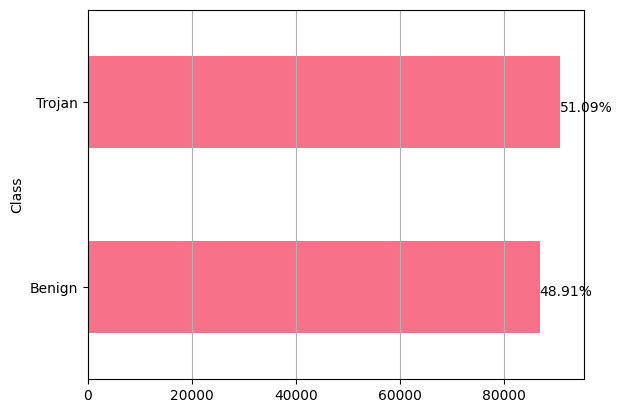

In [70]:
ax = dataset["Class"].value_counts().sort_values().plot(kind="barh")

totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")

plt.show()

Распределение почти равномерное, работы для устанения дисбаланса проводить не будем

In [71]:
print(dataset.columns)

Index([' Source Port', ' Destination Port', ' Protocol', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Fl

In [72]:
# сохраняем только числовые столбцы. Категориальные кодируем в числовые. Целевую переменную (если она есть) - убираем

cols_for_normalization = [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
                           'Total Length of Fwd Packets',' Total Length of Bwd Packets',
  ' Fwd Packet Length Max', ' Fwd Packet Length Min',
  ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
  'Bwd Packet Length Max', ' Bwd Packet Length Min',
  ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
  ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
  ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
  ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
  ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min',
  ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
  ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
  ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
  ' Down/Up Ratio', ' Average Packet Size', ' Avg Fwd Segment Size',
  ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Subflow Fwd Packets',
  ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
  'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
  ' min_seg_size_forward', 'Active Mean',
  ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
  ' Idle Max', ' Idle Min']

In [73]:
# Нормализовать количественные признаки
scaler = StandardScaler()
dataset[cols_for_normalization] = scaler.fit_transform(dataset[cols_for_normalization])
dataset.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,49975,80,6,-0.038628,-0.092527,-0.055528,-0.072645,-0.063037,0.361791,-0.196660,...,-1.172879,-0.182251,-0.082902,-0.183967,-0.168433,-0.294288,-0.123948,-0.300704,-0.281380,Trojan
1,49169,443,17,-0.494134,-0.025086,-0.027333,0.392864,-0.032898,2.856531,0.364232,...,-1.172879,-0.182251,-0.082902,-0.183967,-0.168433,-0.294288,-0.123948,-0.300704,-0.281380,Trojan
2,37749,53,17,-0.460739,-0.193689,-0.083723,-0.129121,-0.066285,-0.510603,0.246150,...,0.631082,-0.182251,-0.082902,-0.183967,-0.168433,-0.294288,-0.123948,-0.300704,-0.281380,Benign
3,41352,53,17,-0.492733,-0.193689,-0.083723,-0.127469,-0.066766,-0.485094,0.393753,...,-1.172879,-0.182251,-0.082902,-0.183967,-0.168433,-0.294288,-0.123948,-0.300704,-0.281380,Trojan
4,44353,443,6,2.344980,0.177238,0.000862,-0.007418,-0.030421,0.440868,-0.196660,...,0.631082,0.231390,-0.082902,0.182973,0.261304,3.614255,-0.123948,3.404620,3.725794,Benign


In [74]:
label_enc = LabelEncoder()
dataset['Class'] = label_enc.fit_transform(dataset['Class'])

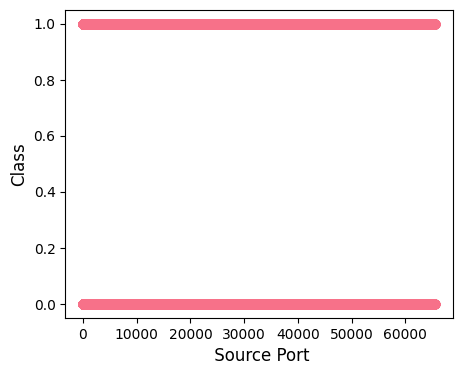

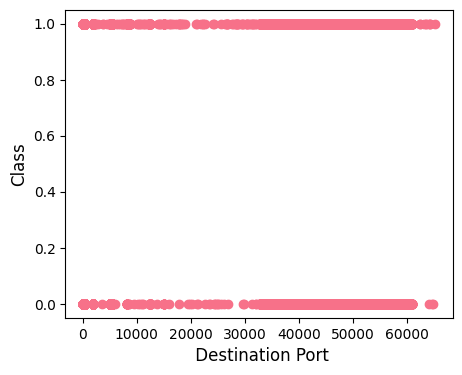

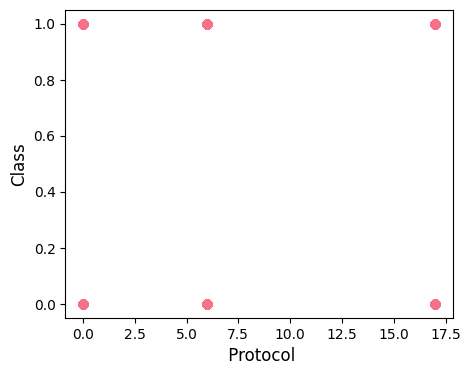

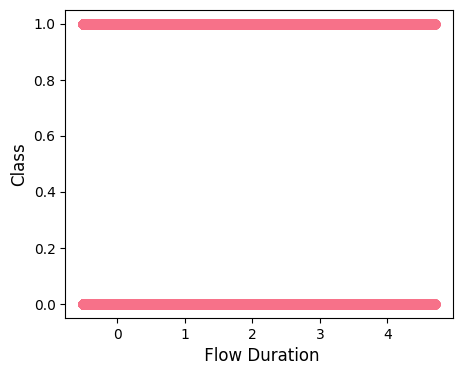

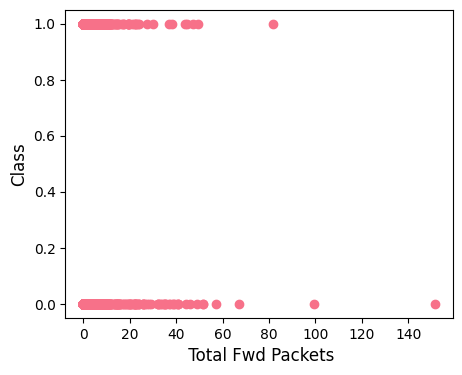

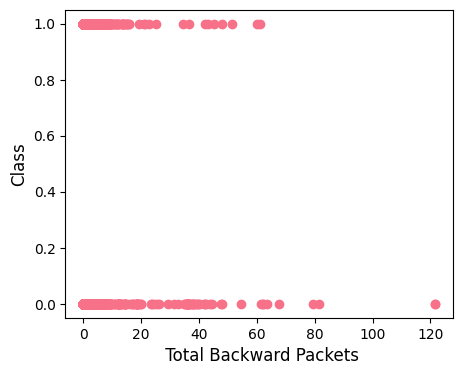

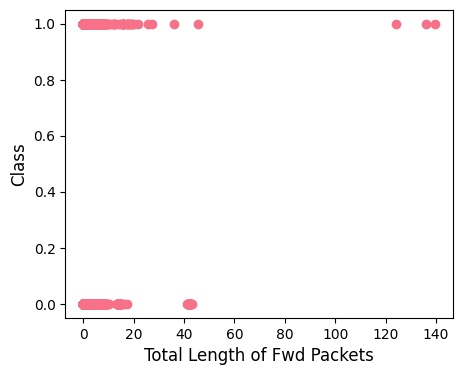

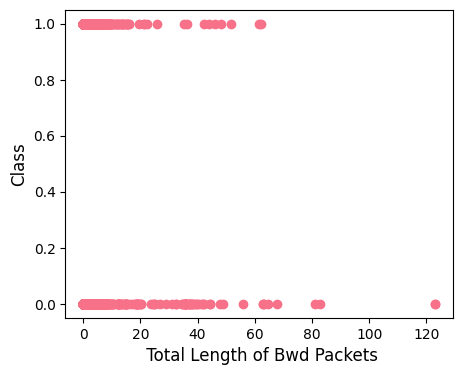

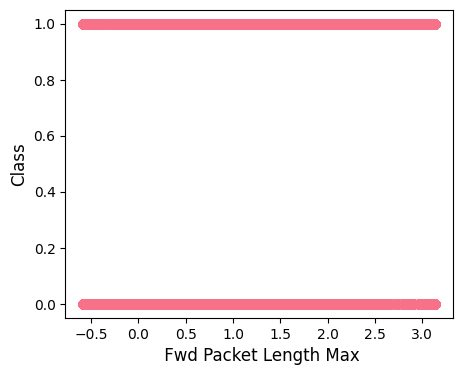

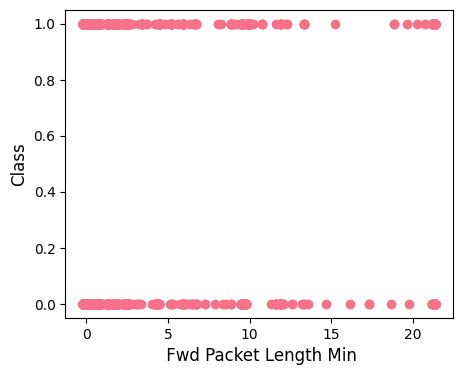

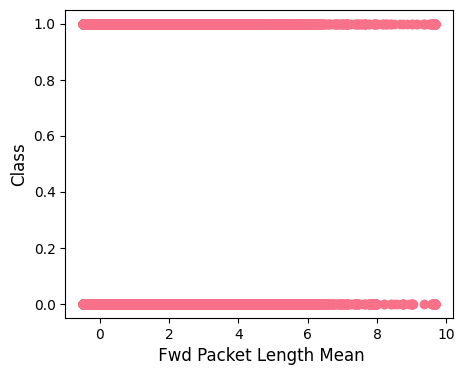

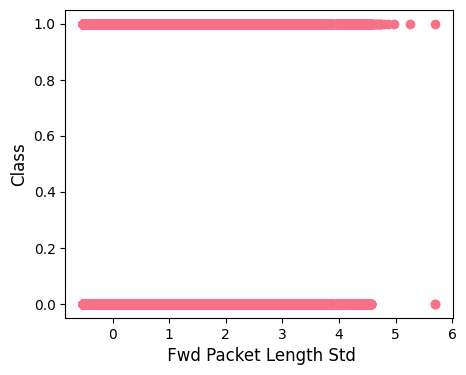

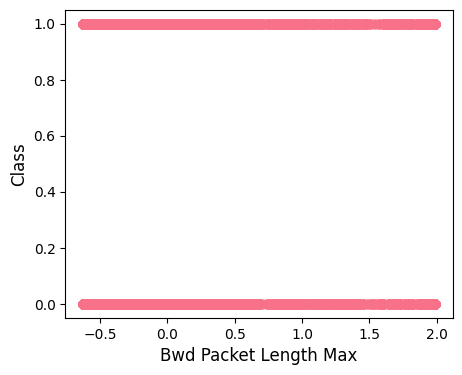

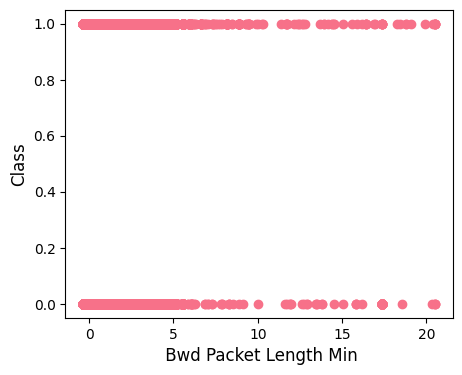

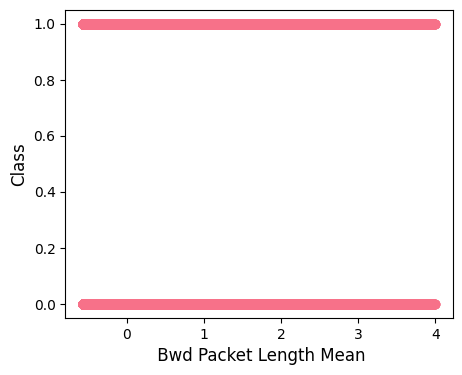

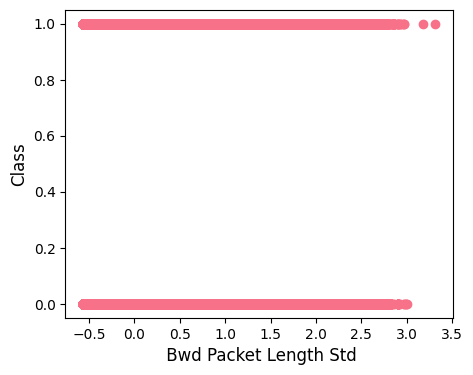

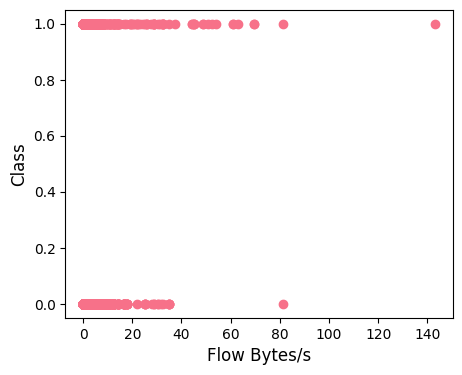

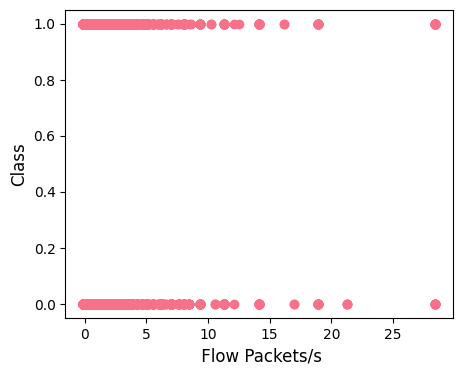

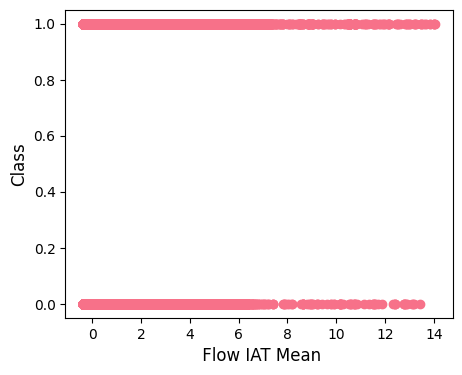

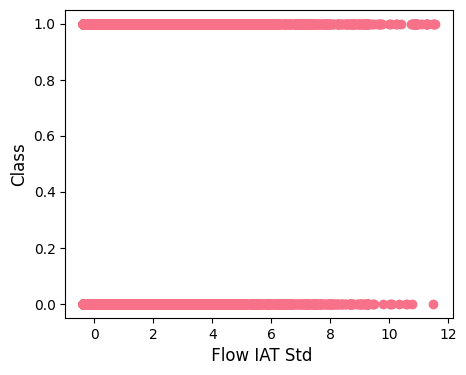

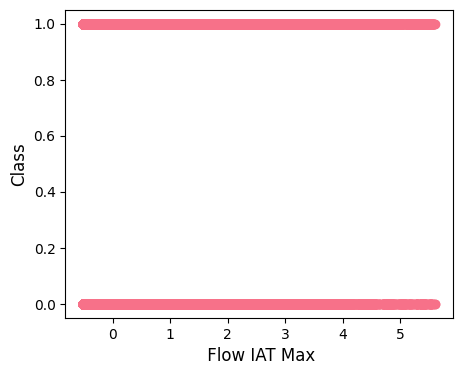

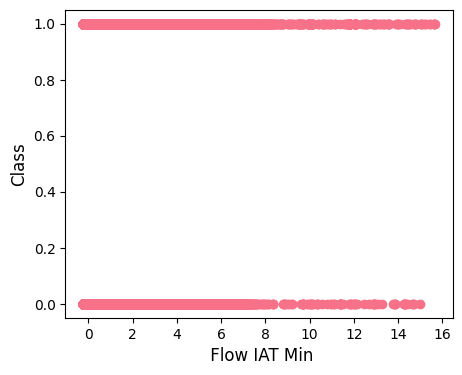

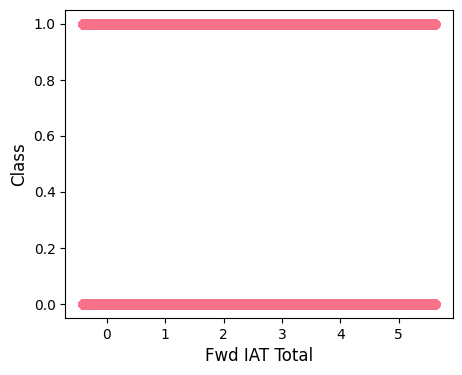

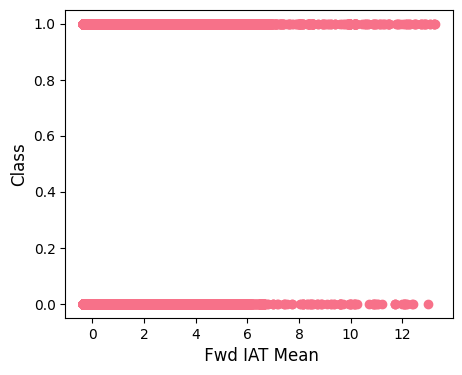

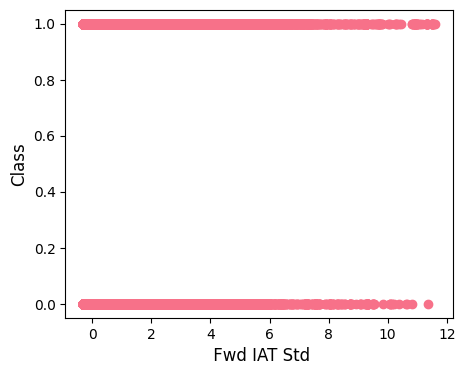

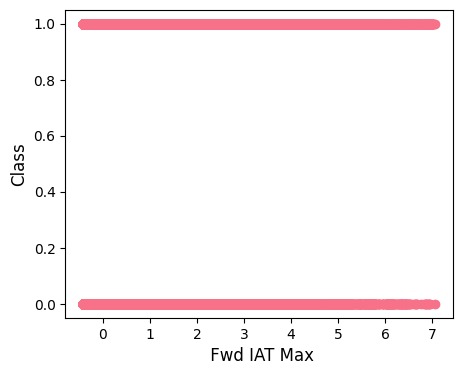

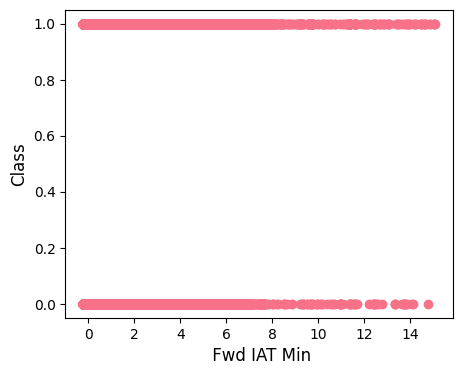

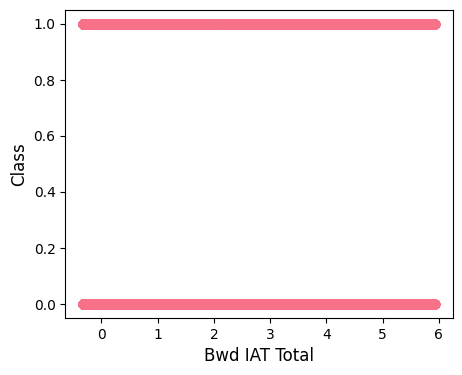

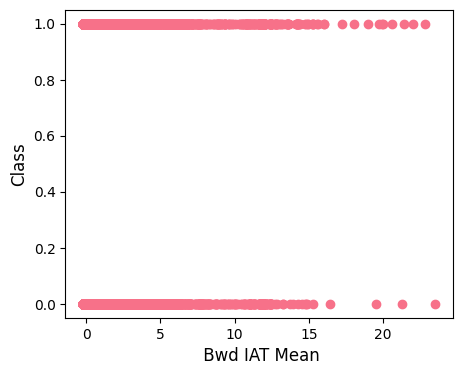

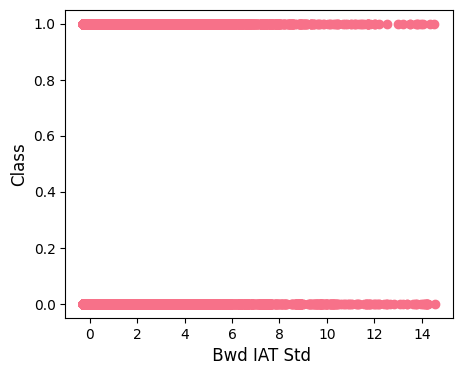

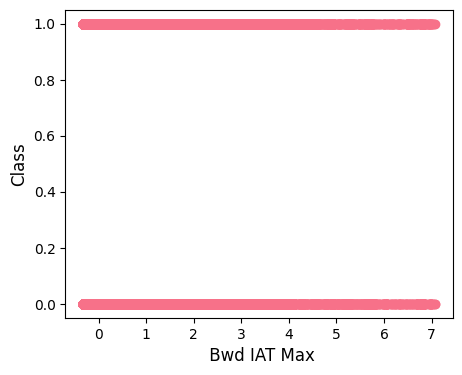

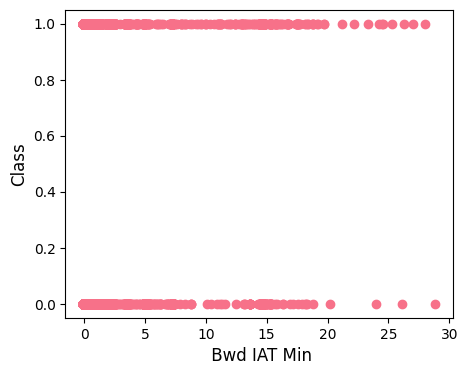

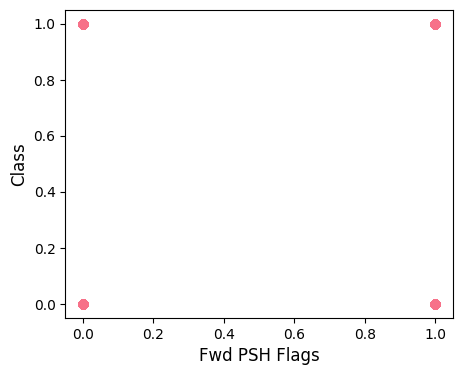

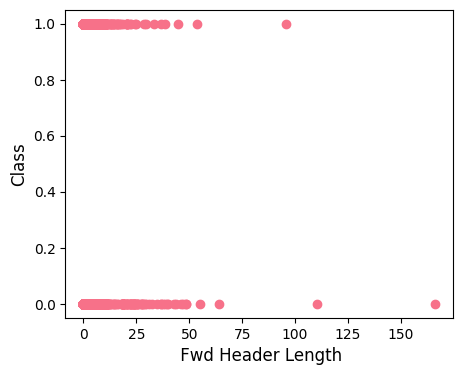

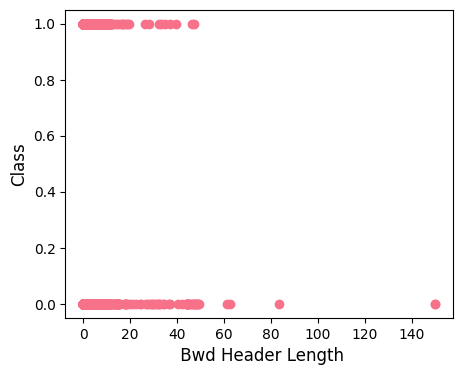

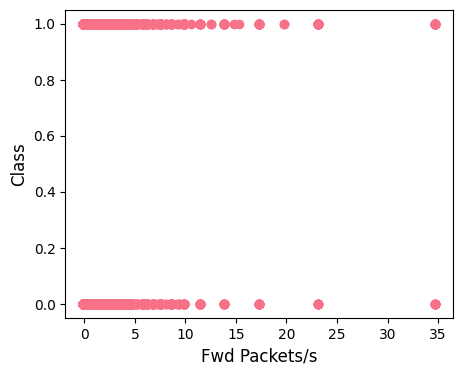

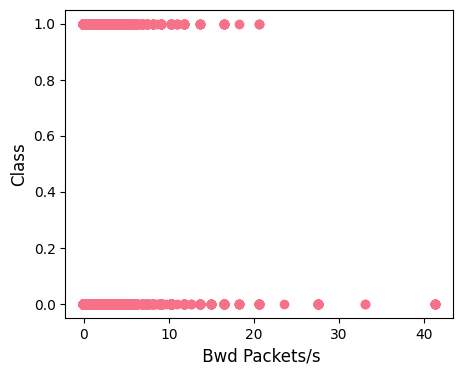

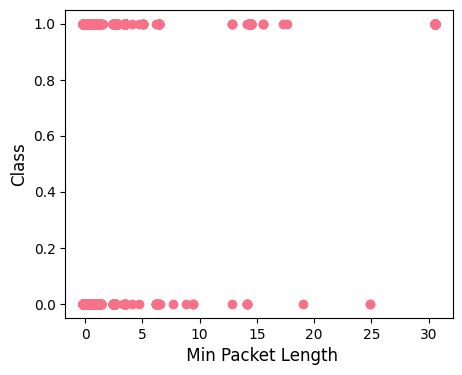

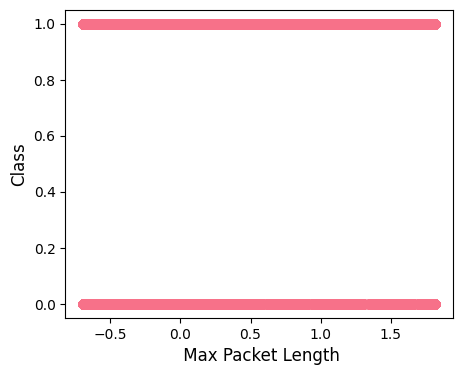

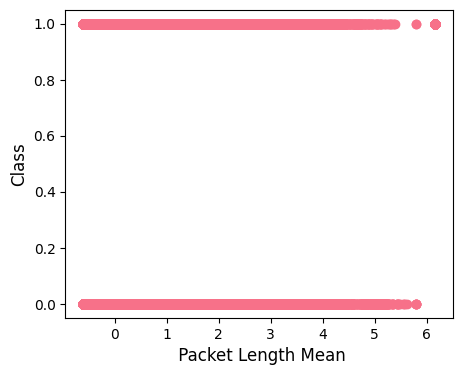

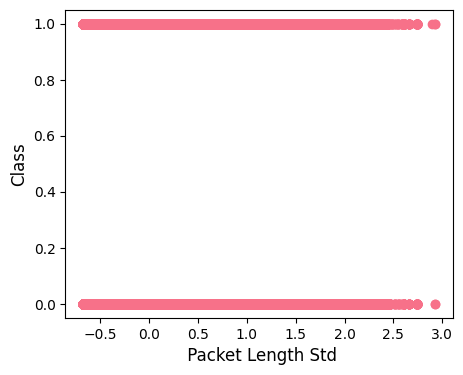

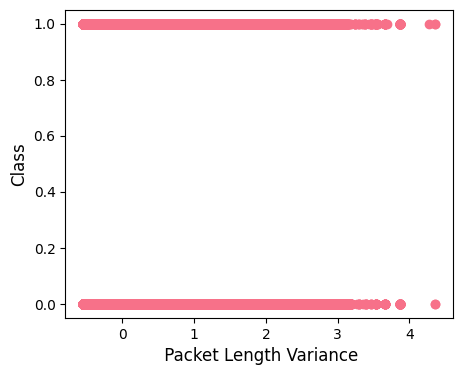

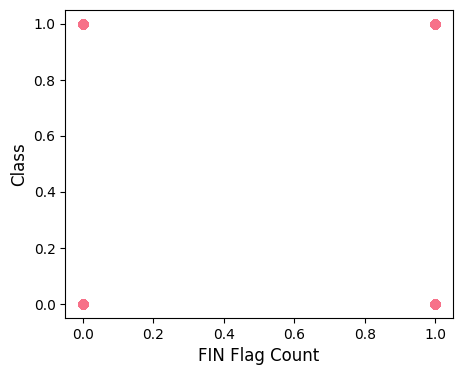

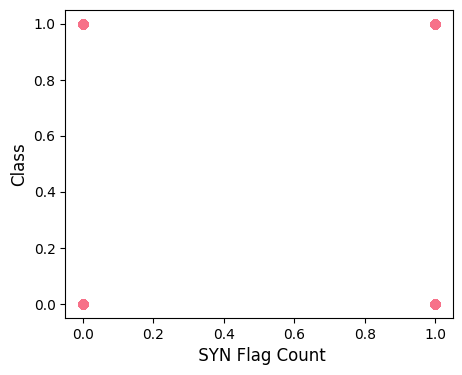

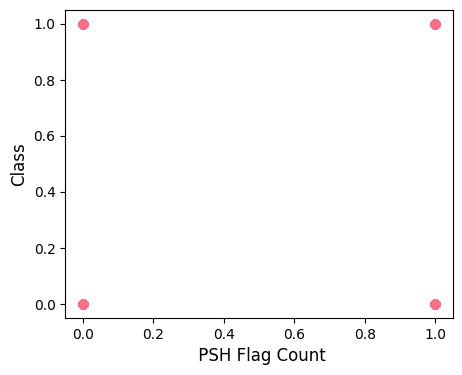

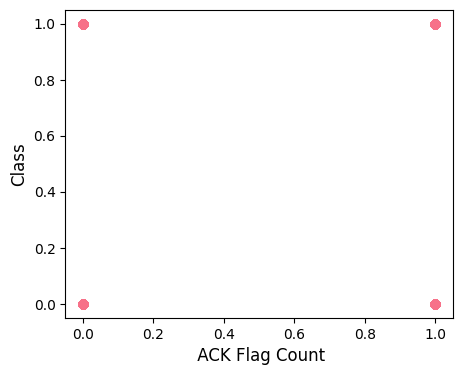

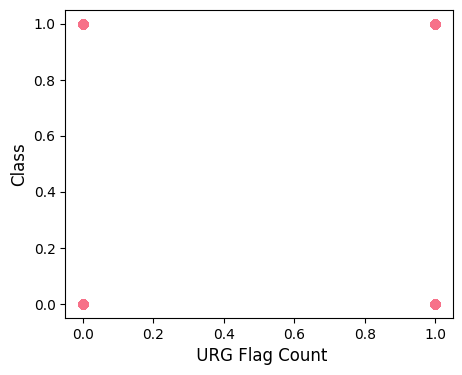

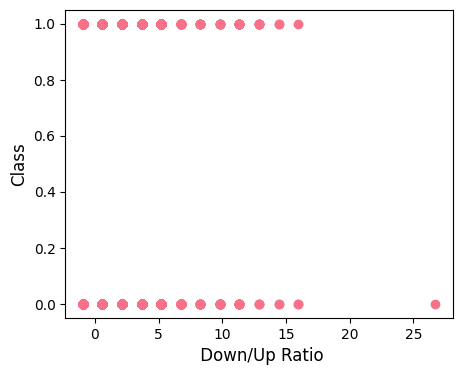

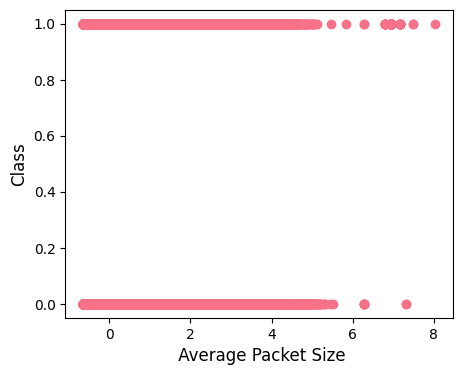

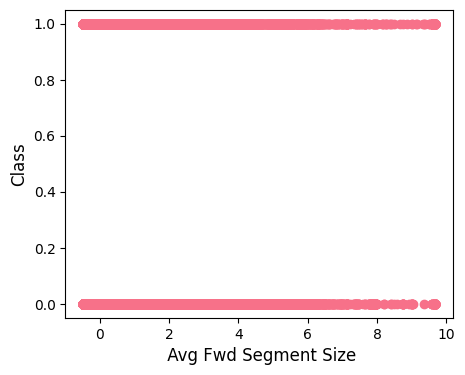

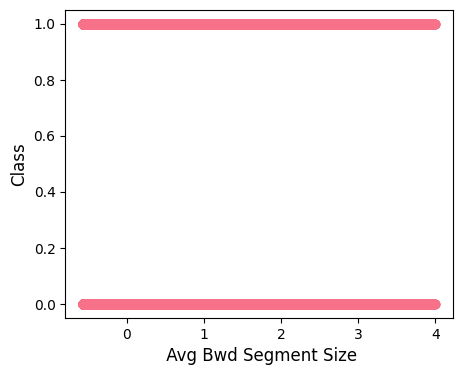

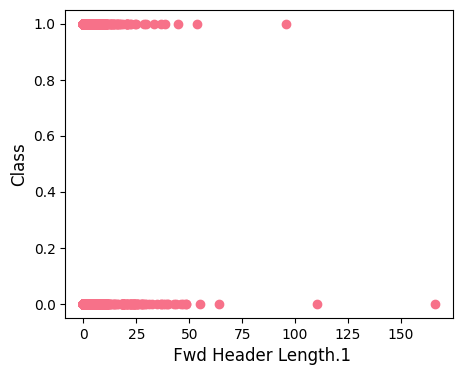

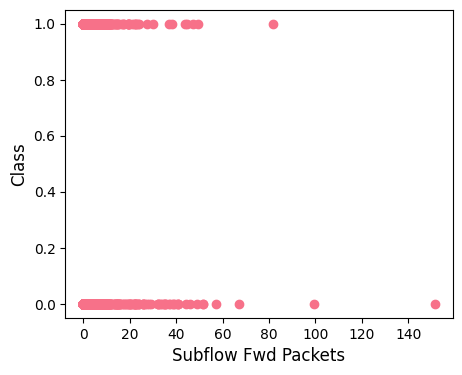

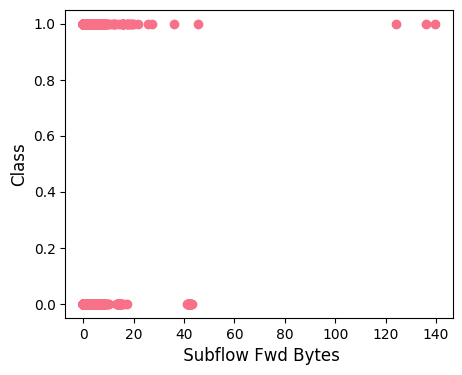

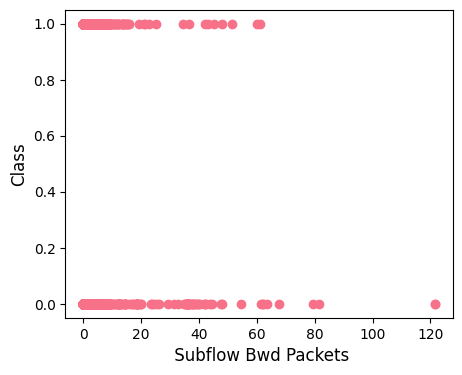

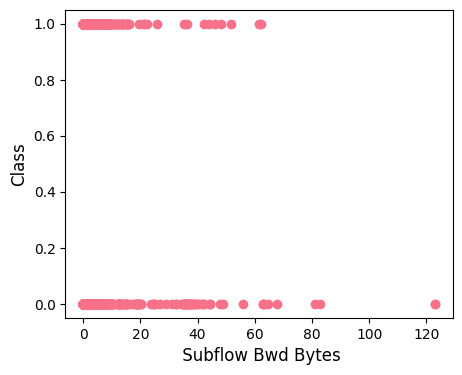

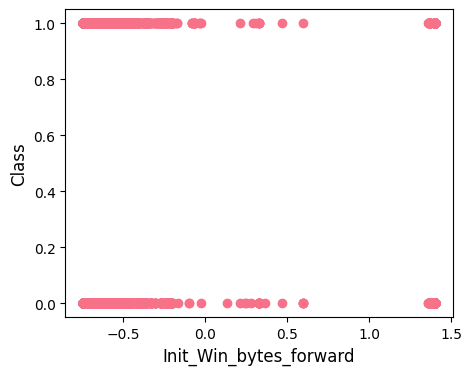

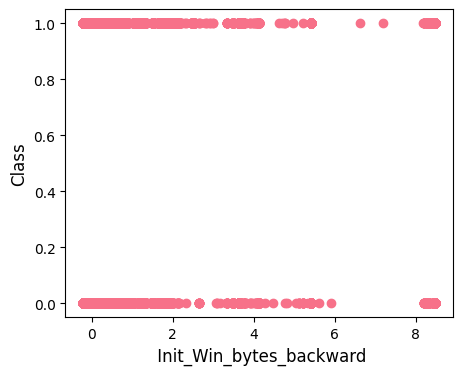

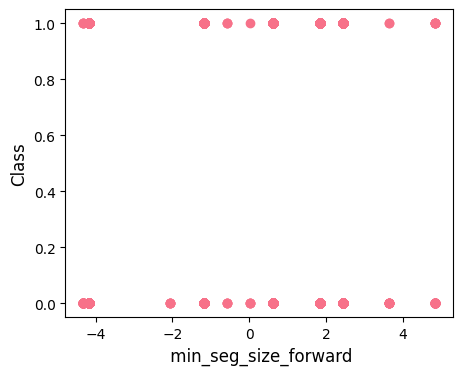

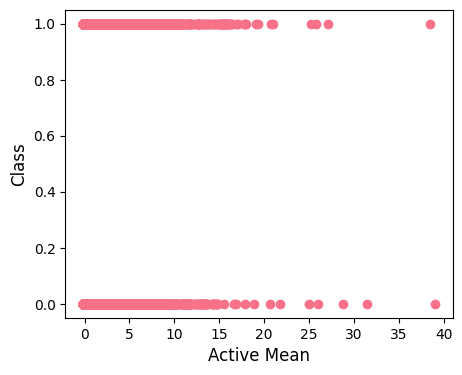

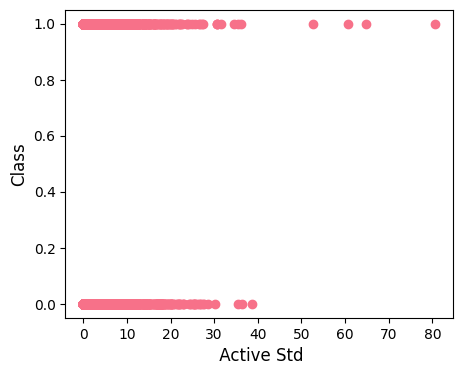

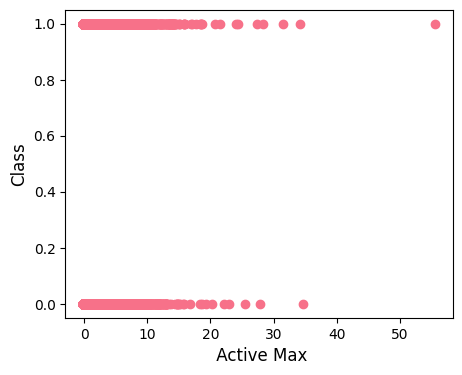

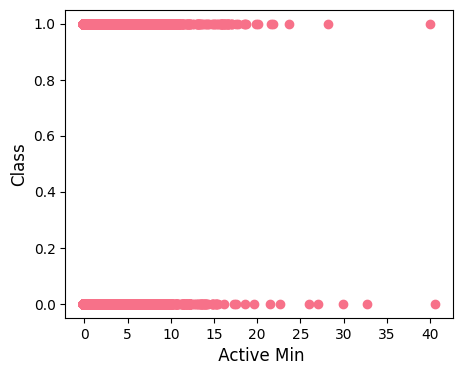

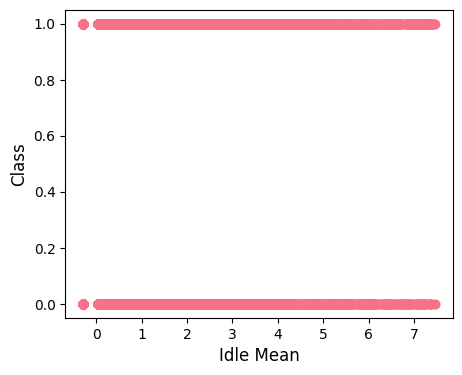

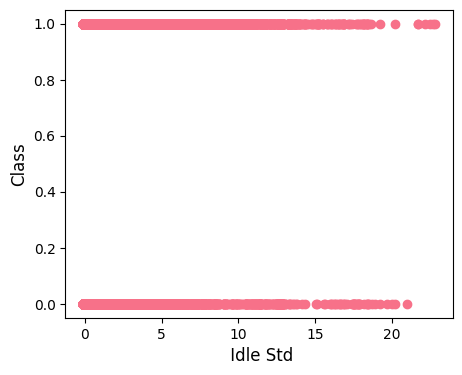

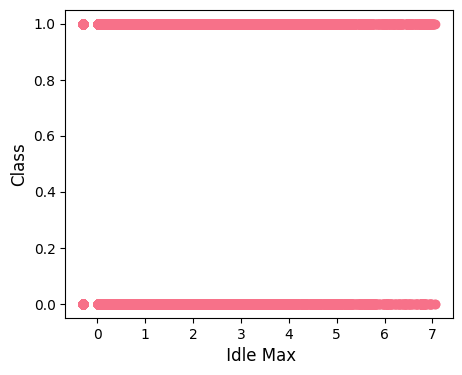

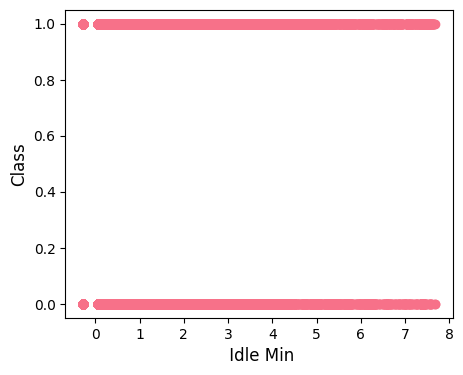

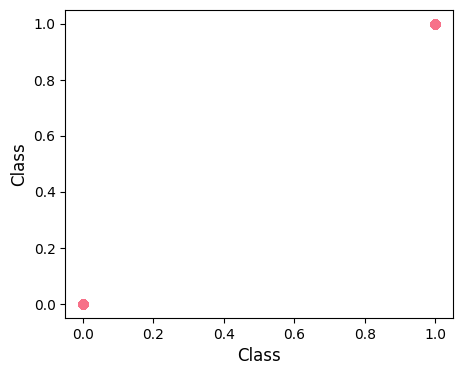

In [75]:
# нарисуем диаграммы рассеяния, чтобы лучше понять, как признаки (фичи) связаны с целевой переменной
for index, feature_name in enumerate(dataset.columns):
    plt.figure(figsize=(5, 4))
    plt.scatter(dataset[feature_name], dataset['Class'])  # Замените 'disease' на имя вашего целевого столбца
    plt.ylabel('Class', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()

df = dataset.copy() # делаем копию, чтобы не было сюрпризов с исходным набором данных


Определям важность каждой фичи при помощи RandomForestClassifier

In [86]:
# Определяем признаки и целевую переменную
y = df['Class']                  # Целевая переменная
X = df.drop(columns=['Class'])  # Все колонки кроме 'Class'

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
X = X_train.values
y = y_train.values
feature_names = X_train.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

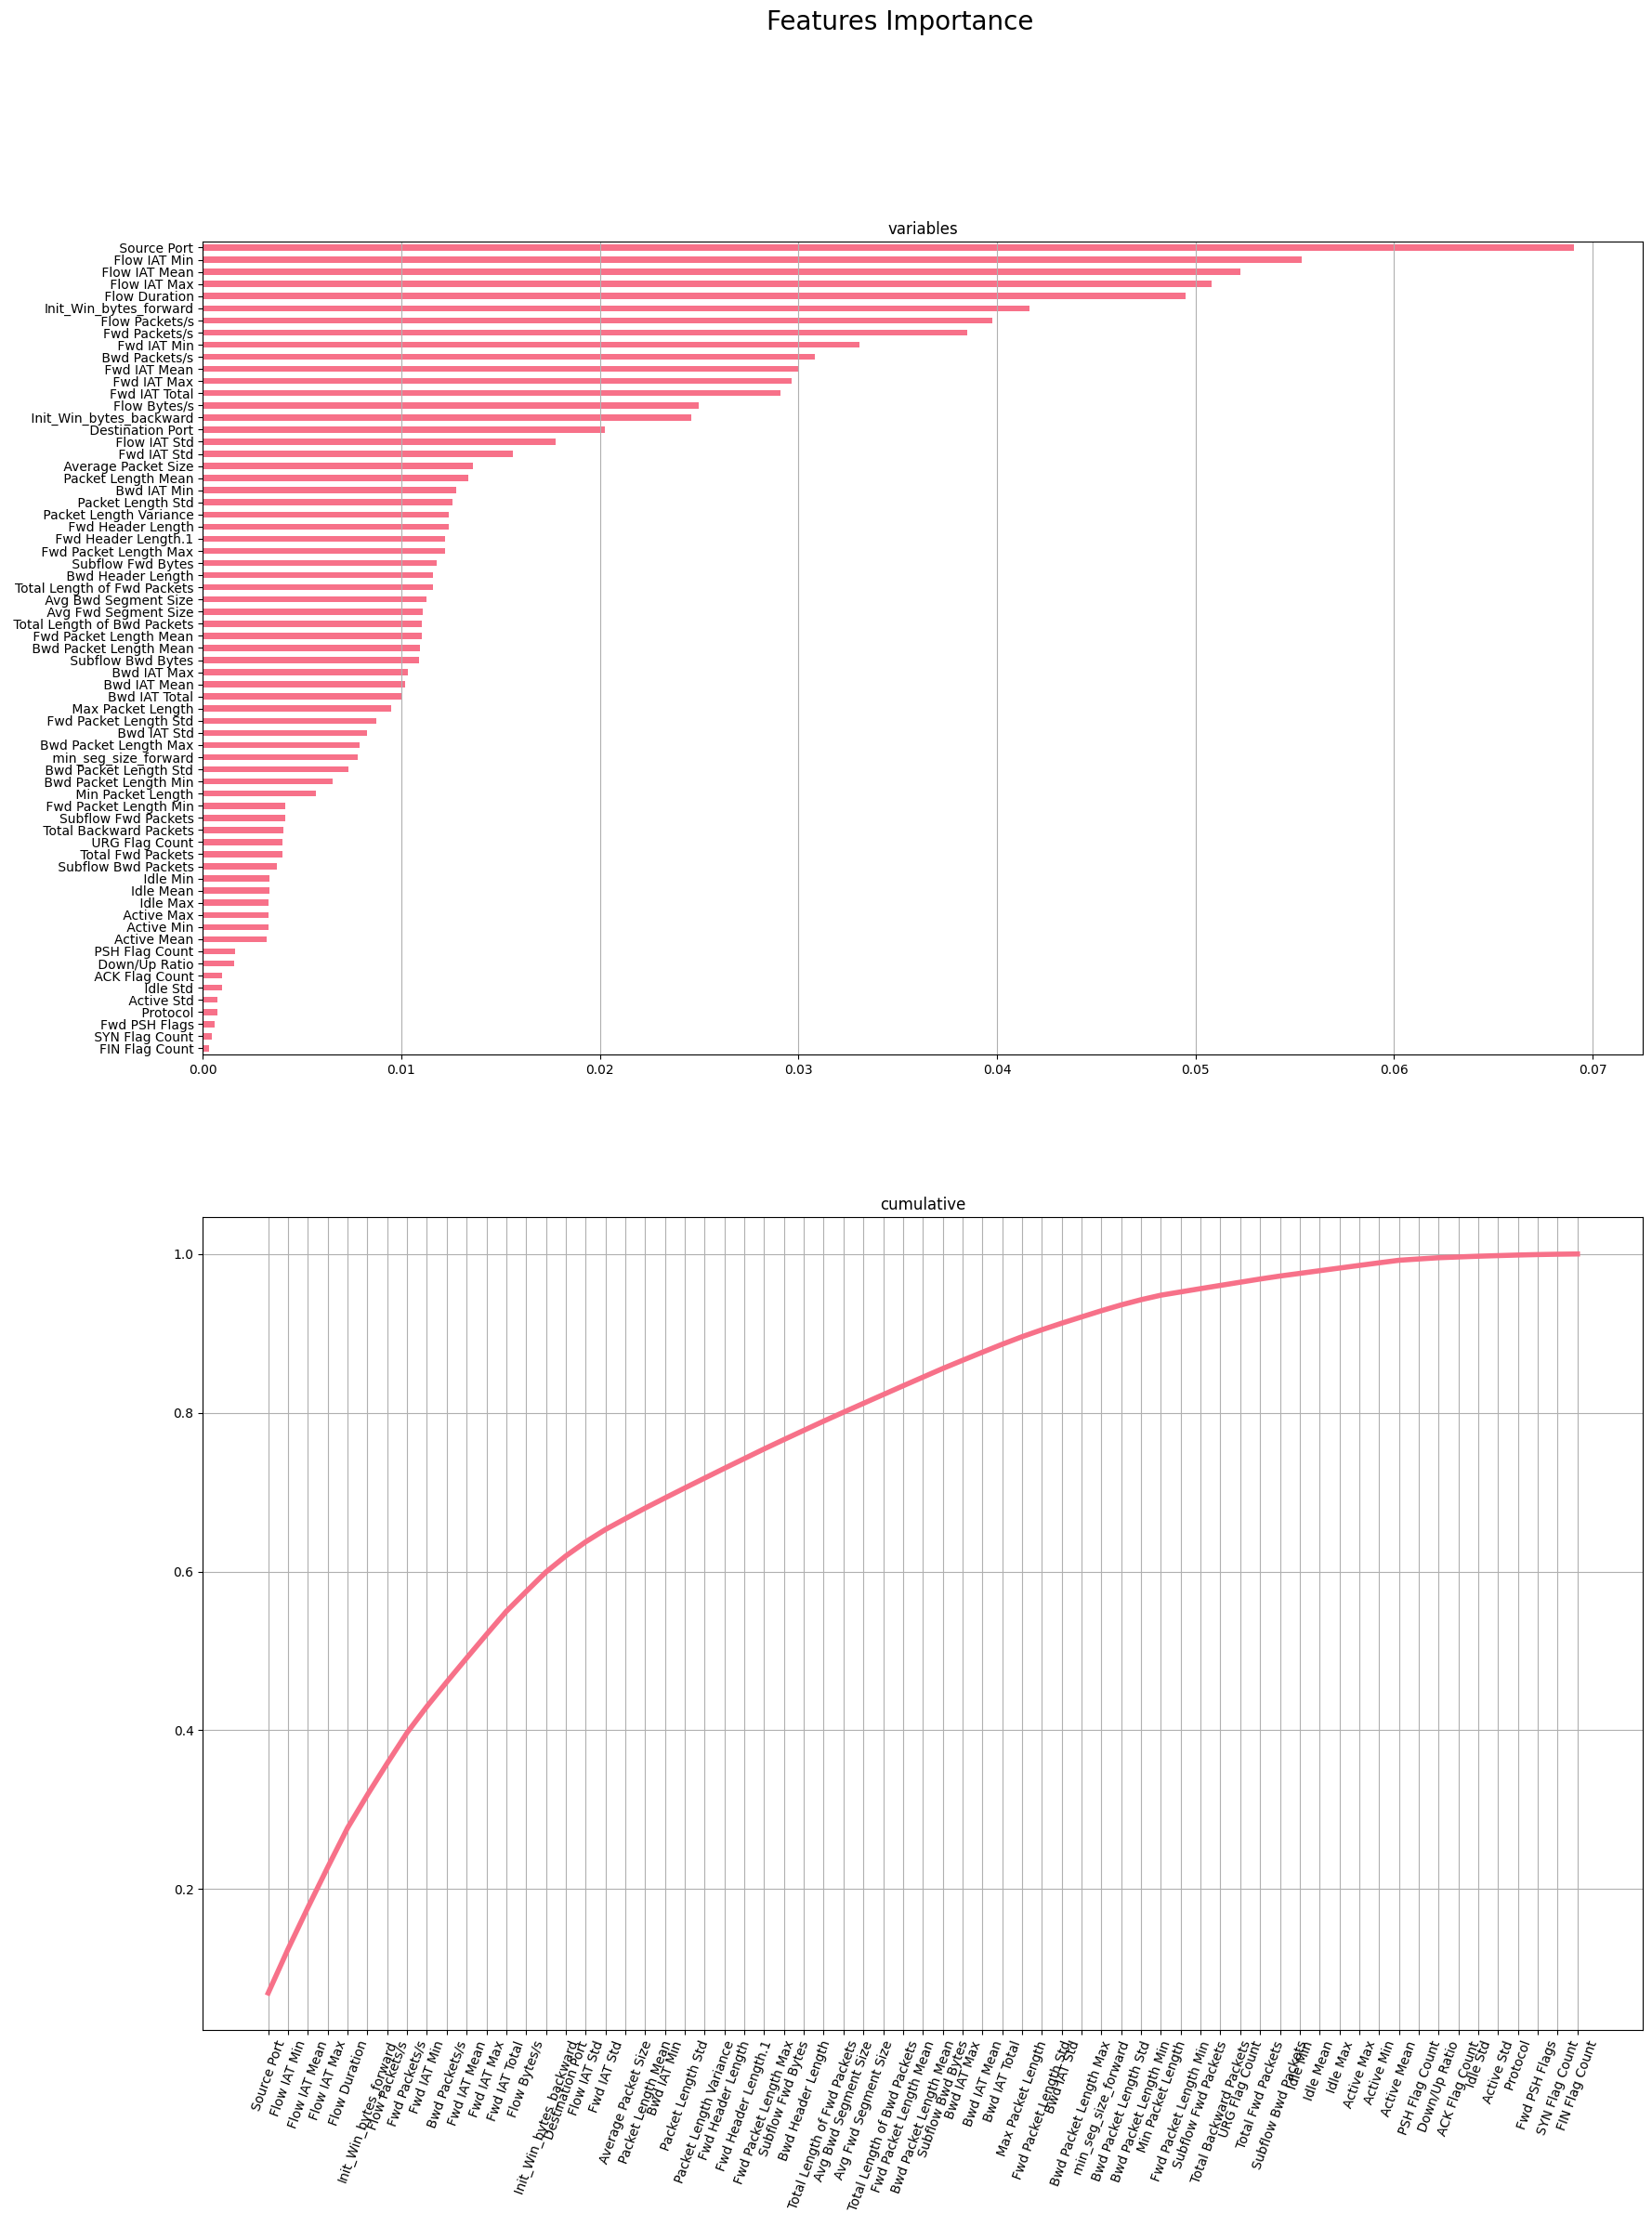

In [96]:
## Plot
'''
 Формируем надписи для графика

 ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plt.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.


'''
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False,figsize=(20,25),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

Исходя из результатов анализа можно сделать выводы, что все фичи после "Total Length of Fwd Packets" нам в принципе не делают никакого значимого вклада.

In [100]:
# Удаляем ненужные фичи, чтобы обучить модель
dataset = dataset.drop([' Protocol',
       ' Total Fwd Packets', ' Total Backward Packets',
       ' Total Length of Bwd Packets',
       ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', 'Fwd PSH Flags',
       ' Min Packet Length', ' Max Packet Length',
       'FIN Flag Count', ' SYN Flag Count', ' PSH Flag Count',
       ' ACK Flag Count', ' URG Flag Count', ' Down/Up Ratio', ' Avg Fwd Segment Size',
       ' Avg Bwd Segment Size', 'Subflow Fwd Packets',
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
       ' min_seg_size_forward', 'Active Mean', ' Active Std', ' Active Max',
       ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min'], axis=1)

In [101]:
print(dataset.columns)

Index([' Source Port', ' Destination Port', ' Flow Duration',
       'Total Length of Fwd Packets', ' Fwd Packet Length Max', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', ' Bwd IAT Min', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' Average Packet Size', ' Fwd Header Length.1', ' Subflow Fwd Bytes',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward', 'Class'],
      dtype='object')


Далее необходимо:
1) разделить датасет
2) обучить модели классификации
3) применить кросс-валидацию
4) построить ROC-кривые
5) посмотреть матрицу ошибок
6) выбрать лучшую модель

### Распространенные алгоритмы кластеризации

